In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from glob import glob
import time

# get_ipython().magic('matplotlib inline')

In [2]:
def construct_H_matrix(x, xs):
    '''
        Construct the correspondance matrix for estimating Homography
        
        Keyword Arguments:
            x  -- Image points from the First image
            xs -- Image points from the Second Image
        
        Return Values:
            A  -- Constructed correspondance matrix
    '''
    A = np.zeros((0, 9))
    for i in range(len(x)):
        a = np.array([
            [x[i][0], x[i][1], 1, 0, 0, 0, -xs[i][0]*x[i][0], -xs[i][0]*x[i][1], -xs[i][0]],
            [0, 0, 0, x[i][0], x[i][1], 1, -xs[i][1]*x[i][0], -xs[i][1]*x[i][1], -xs[i][1]],
            ])
        A = np.concatenate((A, a))
    return A

In [3]:
def transform_points(H, x):
    '''
        Given homography transforms points into the homography frame of reference
        
        Keyword Arguments:
            H  -- 3*3 homography matrix
            x  -- N*2 Points to be transformed
        
        Return Values:
            xs  -- N*3 Transformed Points
    '''
    # Convert points into homogeneous coordinates
    x_homogeneous = np.concatenate((x, np.ones((len(x), 1))), axis=1)

    # Calculate the transformed points and normalize them
    xs = H @ x_homogeneous.T
    xs[0, :] = xs[0, :] / xs[2, :]
    xs[1, :] = xs[1, :] / xs[2, :]
    xs[2, :] = xs[2, :] / xs[2, :]
    xs = xs.T

    return xs  

In [4]:
def calculate_transformation_error(H, x, xs):
    '''
        Calculate the transformation error between the transformed points and the ground truth
        
        Keyword Arguments:
            H                     -- 3*3 homography matrix
            x                     -- N*2 points to be transformed
            xs                    -- N*2 ground truth points
        
        Return Values:
            transformation_error  -- Return the L2 norm of the error
    '''
    # Convert points into homogeneous coordinates
    xs_homogeneous = np.concatenate((xs, np.ones((len(xs), 1))), axis=1)

    # Calculate the projected points
    transformed_coords = transform_points(H, x)

    # Calculate the projection error
    transformation_error =  np.linalg.norm(xs_homogeneous - transformed_coords, axis=1)

    return transformation_error 

## RANSAC
- For better estimation of the homography matrix, we perform RANSAC and try to get the homography matrix with maximum inliers.
- We calculate the inliers based on the transformation error, which is required to be below a certain preset threshold that we choose.

In [5]:
def RANSAC(img_coords_1, img_coords_2, num_points, max_iterations=30000, thresh=0.1):
    '''
        Get the best estimate of the Homography Matrix using RANSAC
        
        Keyword Arguments:
            img_coords_1   -- Coordinates of the first image after matching
            img_coords_2   -- Coordinates of the first image after matching
            num_points     -- Number of matched points
            max_iterations -- Maximum Number of iterations to run RANSAC for (default=20000)
            thresh         -- Threshold to compute inliers (default=0.1)
        
        Return Values:
            H              -- Estimated Homography matrix using RANSAC
    '''
    min_transform_error = 999999999
    max_inliers = -999999999

    # Best estimate of Projection matrix by far
    _H = np.zeros((3, 3))

    inliers = []

    for i in range(max_iterations):

        # Randomly select 4 world points and the corresponding image points
        idx = random.sample(range(0, num_points), 4)       
        x  = img_coords_1[idx]
        xs = img_coords_2[idx]

        # Perform DLT and get the Transformation Matrix
        H = DLT(x, xs)

        # Calculate projection error
        transformation_error = calculate_transformation_error(H, img_coords_1, img_coords_2)


        inliers = np.sum(transformation_error<thresh)

        if inliers > max_inliers:
            max_inliers = inliers
            _H = H

        # Repeat for a maximum number of iterations
    
    return _H

## Estimating the Homography Matrix
* To estimate the homography matrix we perform a DLT like estimation
* $x_2 = H_{21}\cdot x_1$ 
* \begin{equation}
        \begin{bmatrix}
            wx_{21} \\
            wx_{22} \\
            w
        \end{bmatrix}
        =
        \begin{bmatrix}
            h_1 & h_2 & h_3 \\
            h_4 & h_5 & h_6 \\
            h_7 & h_8 & h_9 \\
        \end{bmatrix}
        \cdot
        \begin{bmatrix}
            x_{11} \\
            x_{12} \\
           1
        \end{bmatrix}
  \end{equation}
* We take the SVD of the correspondance matrix which we define in the following way
* \begin{bmatrix}
        x_1 & y_1 & 1 & 0 & 0 & 0 & -x_2 x_1 & -x_2 y_1 & -x_2 \\
        0 & 0 & 0 & x_1 & y_1 & 1 & -y_2 x_1 & -y_2 y_1 & -y_2 \\
  \end{bmatrix}
* We require at least 4 points in order to estimate the homography matrix as it has 8 degrees of freedom. The ninth degree is removed due to scale ambiguity. 
* We minimize the error, by taking the eigen vector corresponding to the smallest eigen value and reshape that to be our homography matrix

In [6]:
def DLT(x, xs):
    '''
        Estimate Homography matrix using DLT
        
        Keyword Arguments:
            x  -- Image points from the First image
            xs -- Image points from the Second image
        
        Return Values:
            A  -- Estimated Homography Matrix
    '''
    # Construct the DLT Matrix
    A = construct_H_matrix(x, xs)


    # Perform SVD on the Matrix
    U, s, Vh = np.linalg.svd(A.T @ A)

    # Extract the 9th row and Normalize it
    A = Vh[-1, :] / Vh[-1, -1]

    # Reshape the row and get the projection matrix
    A = A.reshape(3, 3)

    return A

In [7]:
def find_matching_points(image1, image2, num_points=500):
    '''
        Find matching points between two images using SIFT
        
        Keyword Arguments:
            image1  -- Image 1
            image2  -- Image 2
            num_points -- Maximum number of features
        
        Return Values:
            x  -- Image points from the First image
            xs -- Image points from the Second image
    '''
    # Initiate sift detector
    orb = cv2.xfeatures2d.SIFT_create(nfeatures=num_points)
#     orb = cv2.ORB_create()
    
    # Create BF Matcher
    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    # Find keypoints and descriptors 
    kp1, desc1 = orb.detectAndCompute(image1, None)    
    kp2, desc2 = orb.detectAndCompute(image2, None)

    # Match descriptors
    matches = bf.match(desc1, desc2) 

    # Sort the matches in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)[:80]

    # Draw first 10 matches.
    img3 = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)

    plt.imshow(img3),plt.show()
    
    if len(matches) >= 4:
        x = np.array([ kp1[m.queryIdx].pt for m in matches ])#.reshape(-1,1,2)
        xs = np.array([ kp2[m.trainIdx].pt for m in matches ])#.reshape(-1,1,2)
    return x, xs

In [8]:
def warp_image(image_1, image_2, H):
    '''
        Warp image_2 to image_1 frame
        
        Keyword Arguments:
            image_1  -- Image to warp to
            image_2  -- Image to be warped
            H        -- 3*3 homography matrix
        
        Return Values:
            im_out  -- Warped image
    '''
    im_out = cv2.warpPerspective(image_2, H, (image_1.shape[1] + image_2.shape[1], image_1.shape[0] + image_2.shape[0]))
    return im_out

In [9]:
def crop_image(image, tolerence=0):
    '''
        Crop out black spaces from images by contouring
        
        Keyword Arguments:
            image  -- Image to be cropped
        
        Return Values:
            crop  -- Cropped image
    '''
    mask = image > tolerence
    if image.ndim==3:
        mask = mask.any(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    return image[np.ix_(mask1,mask0)]

## Image Stitching / Mosaicing
- In order to perform image stitching, we compute the homography between two images using RANSAC.
- After having computed the homography, we transform the second image in the first images reference frame.
- Then, we superimpose both the transformed and the first image in order to create the resultant stitched image.
- In order to stitch multiple images together, we take the resultant image we obtained from the above step and repeat the algorithm
- It is beneficial to perform the process with the resultant immage as we get more keypoints which matching a new image and thus relieving us to provide the images in a certain order.

In [10]:
def stitch_images(images):
    '''
        Given a set of images, perform image mosaicing and stitch the images.
        
        Keyword Arguments:
            images  -- Set of images of be stitched
        
        Return Values:
            A  -- Stitched Image
    '''
    result = images[0]
    for i in range(len(images)-1):
        x, xs = find_matching_points(result, images[i+1])
        H = RANSAC(xs, x, len(xs))
        dst1 = warp_image(result, images[i+1], H)

        resultant = np.zeros(dst1.shape).astype('uint8')
        resultant[0:result.shape[0], 0:result.shape[1], :] = result[:,:,:]
        mask = resultant<=0
        resultant[mask] = dst1[mask]
        
        result = crop_image(resultant)

        plt.imshow(result)
        plt.show()
    return result

### Question 1 : Find matches between two partially overlapped images using any feature detector and descriptor

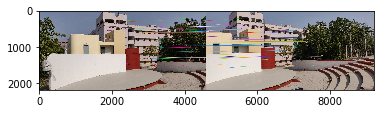

In [11]:
image_files = sorted(glob('./image_mosaicing/img1/*'))
images = []
for im in image_files:
    images.append(cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB))

x, xs = find_matching_points(images[1], images[2])

### Question 2 : Estimate homography matrix between two images robustly using RANSAC

In [12]:
H = RANSAC(xs, x, len(xs))
print("Estimated Homography Matrix:\n",H)

Estimated Homography Matrix:
 [[ 7.19710665e-01 -1.27012982e-02  1.07937023e+03]
 [-7.09968288e-02  8.79695938e-01  1.45898122e+02]
 [-6.17983387e-05 -5.15009841e-06  1.00000000e+00]]


### Question 3 : Transform one of the images to the others reference frame homography matrix

Warped Image


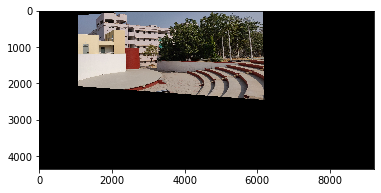

In [13]:
dst1 = warp_image(images[1], images[2], H)
print("Warped Image")
plt.imshow(dst1)
plt.show()

### Question 4 : Stitch the two images together

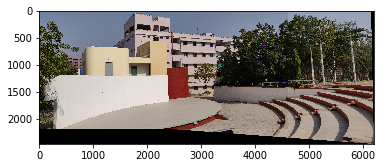

In [14]:
resultant = np.zeros(dst1.shape).astype('uint8')
resultant[0:images[1].shape[0], 0:images[1].shape[1], :] = images[1][:,:,:]
mask = resultant<=0
resultant[mask] = dst1[mask]
resultant = crop_image(resultant)
plt.imshow(resultant)
plt.show()

### Question 5 : Stitch multiple images together

./image_mosaicing/img1


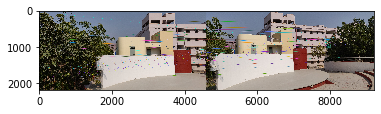

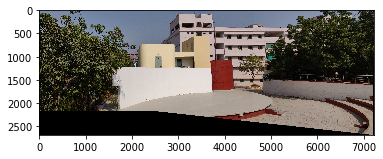

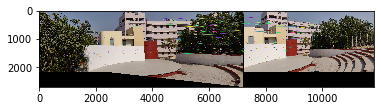

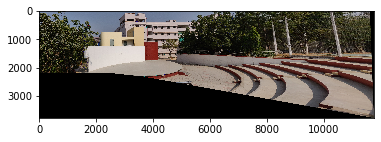

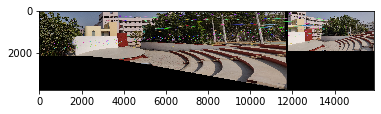

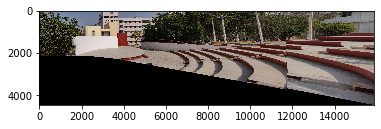

./image_mosaicing/img2


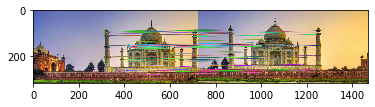

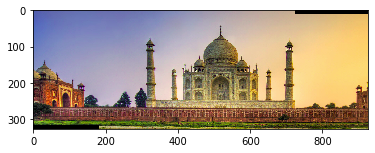

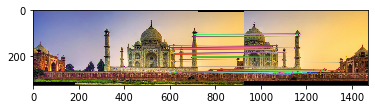

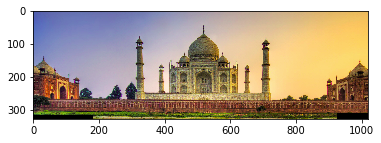

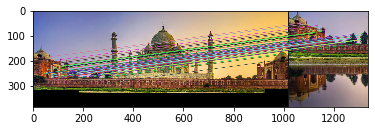

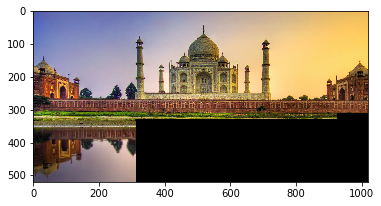

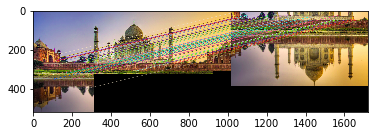

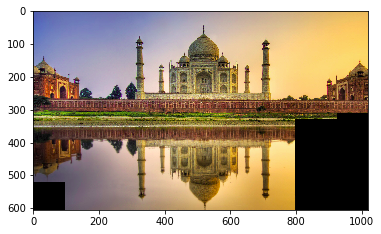

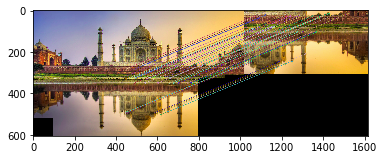

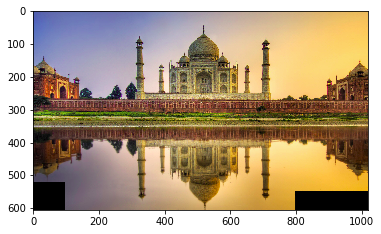

./image_mosaicing/img3


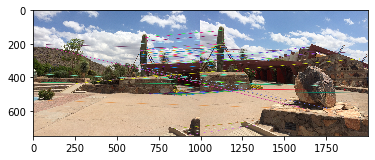

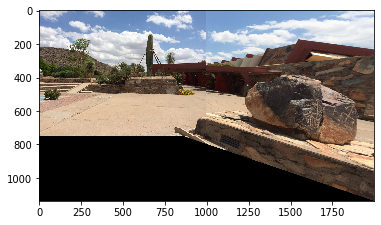

./image_mosaicing/img4


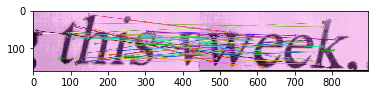

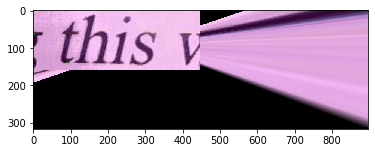

./image_mosaicing/img5


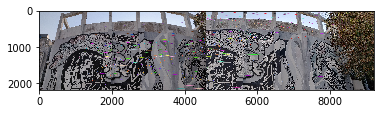

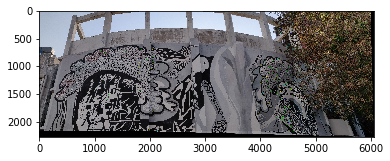

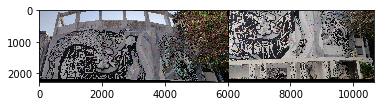

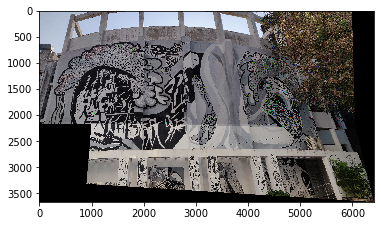

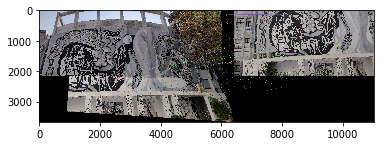

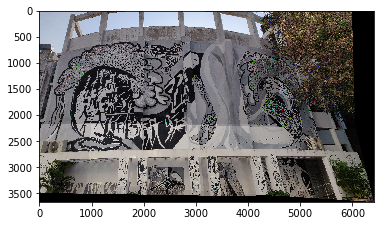

./image_mosaicing/img6


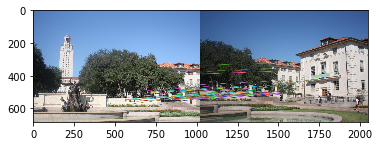

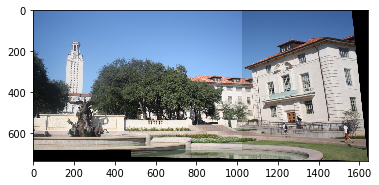

./image_mosaicing/img7


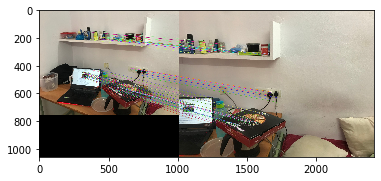

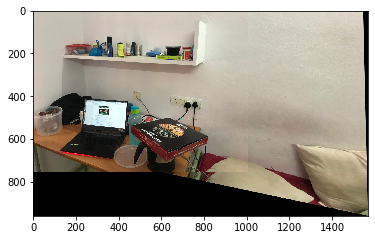

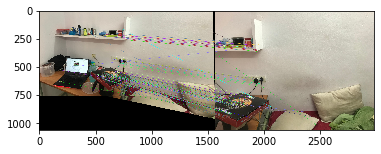

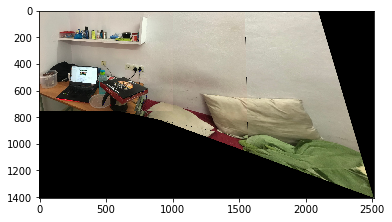

In [17]:
image_dirs = sorted(glob('./image_mosaicing/*'))
stitched_images = []
for direc in image_dirs:
    print(direc)
    image_files = sorted(glob(direc+'/*'))
    images = []
    for im in image_files:
        images.append(cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB))

    stitched_images.append(stitch_images(images))

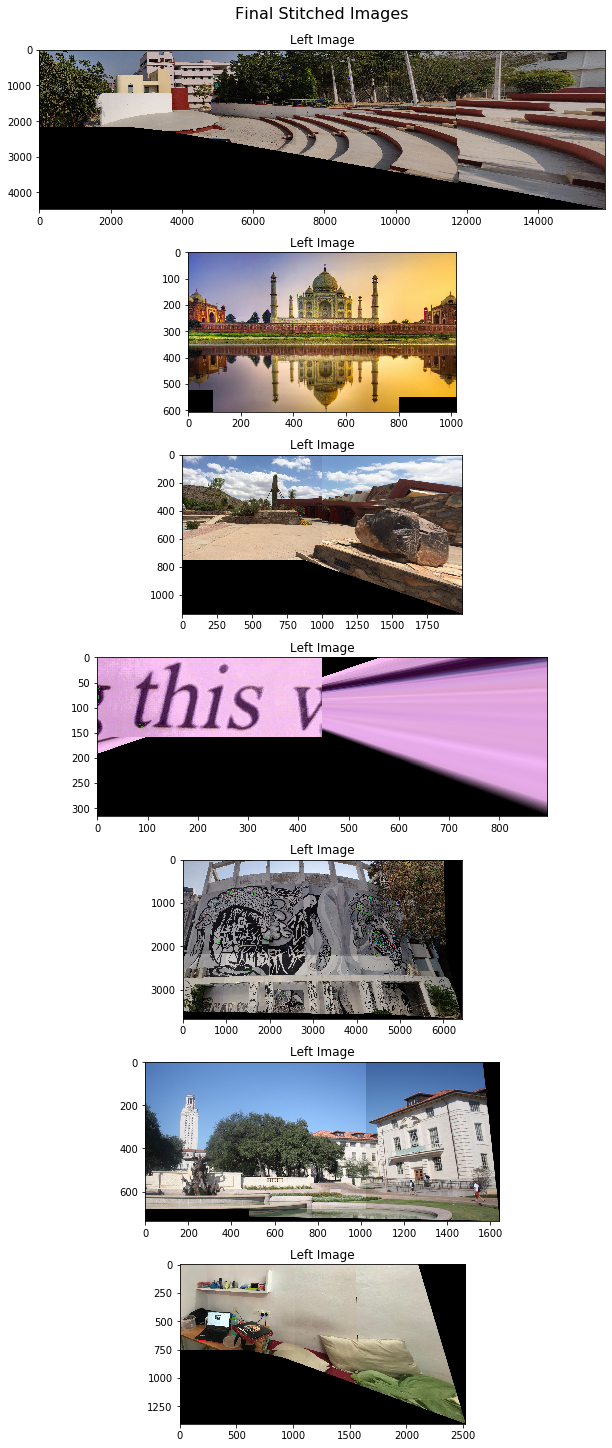

In [18]:
fig3 = plt.figure(constrained_layout=True,figsize=(20, 20))
gs = fig3.add_gridspec(7,1)
for i in range(len(stitched_images)):    
    f3_ax1 = fig3.add_subplot(gs[i])
    f3_ax1.set_title('Left Image')
    plt.imshow(stitched_images[i])
fig3.suptitle('Final Stitched Images', fontsize=16)
plt.show()